O notebook abaixo se refere a análise exploratória dos dados referente aos exames realizados pelos pacientes sépticos nas primeiras 24h e suas informações demográficas.

#### Importação

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import gc
from tqdm import tqdm
from fpdf import FPDF
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.impute import KNNImputer
#from missingpy import MissForest

Os dados "worst_exams_24h" e "sofa_worst_24h" podem ser gerados a partir do notebook extract_exams_24h. Os dados "admissions" e "patients" são tabelas originais da MIMIC-IV.

In [10]:
worst_exams_24h = pd.read_csv("../data/worst/worst_exams_24h_.csv")
sofa_worst_24h= pd.read_csv("../data/worst/sofa_worst_24h.csv")
admissions = pd.read_csv('/scratch/haniel.botelho/physionet.org/files/mimiciv/2.2/hosp/admissions.csv')
patients = pd.read_csv('/scratch/haniel.botelho/physionet.org/files/mimiciv/2.2/hosp/patients.csv')

In [16]:

df_eicu = pd.read_csv('./eicu/df_septico.csv')
df_eicu.columns

Index(['patientunitstayid', 'gender', 'age', 'ethnicity', 'bands', 'CRP',
       'ESR', 'temp', 'lactate', 'WBC', 'lymphs', 'resp', 'spo2/fio2',
       'pao2/fio2', 'bicarbonate', 'heartRate', 'troponin', 'systolic',
       'diastolic', 'MAP', 'bloodUreaNitrogen', 'alanine', 'aspartate',
       'bilirubin', 'hemoglobin', 'iqr', 'platelets', 'PTT', 'fibrinogen',
       'albumin', 'chloride', 'glucose', 'sodium', 'gcs', 'potassium',
       'calcium', 'phosphate', 'magnesium', 'sofascore', 'hospitalid'],
      dtype='object')

In [22]:
categorical = ['gender', 'hospitalid', 'ethnicity']
continuous = [
    'age', 'bands', 'CRP', 'ESR', 'temp', 'lactate', 'WBC', 'lymphs', 'resp', 
    'spo2/fio2', 'pao2/fio2', 'bicarbonate', 'heartRate', 'troponin', 'systolic',
    'diastolic', 'MAP', 'bloodUreaNitrogen', 'alanine', 'aspartate', 'bilirubin',
    'hemoglobin', 'iqr', 'platelets', 'PTT', 'fibrinogen', 'albumin', 'chloride', 
    'glucose', 'sodium', 'gcs', 'potassium', 'calcium', 'phosphate', 'magnesium', 
    'sofascore'
]

In [15]:
total = df_eicu.shape[0]
total

30008

In [10]:
describe = df_eicu[continuous+['gender']].describe()
describe.columns

Index(['bands', 'CRP', 'ESR', 'temp', 'lactate', 'WBC', 'lymphs', 'resp',
       'spo2/fio2', 'pao2/fio2', 'bicarbonate', 'heartRate', 'troponin',
       'systolic', 'diastolic', 'MAP', 'bloodUreaNitrogen', 'alanine',
       'aspartate', 'bilirubin', 'hemoglobin', 'iqr', 'platelets', 'PTT',
       'fibrinogen', 'albumin', 'chloride', 'glucose', 'sodium', 'gcs',
       'potassium', 'calcium', 'phosphate', 'magnesium', 'sofascore',
       'gender'],
      dtype='object')

In [ ]:
# Contar valores nulos e calcular a porcentagem de nulos por coluna
nulos_por_coluna = df_eicu.isnull().sum()
percentual_nulos = (nulos_por_coluna / len(df_eicu)) * 100

# Exibir a contagem e o percentual de nulos por coluna
nulos_df = pd.DataFrame({'Nulos': nulos_por_coluna, 'Percentual (%)': percentual_nulos})
print(nulos_df)


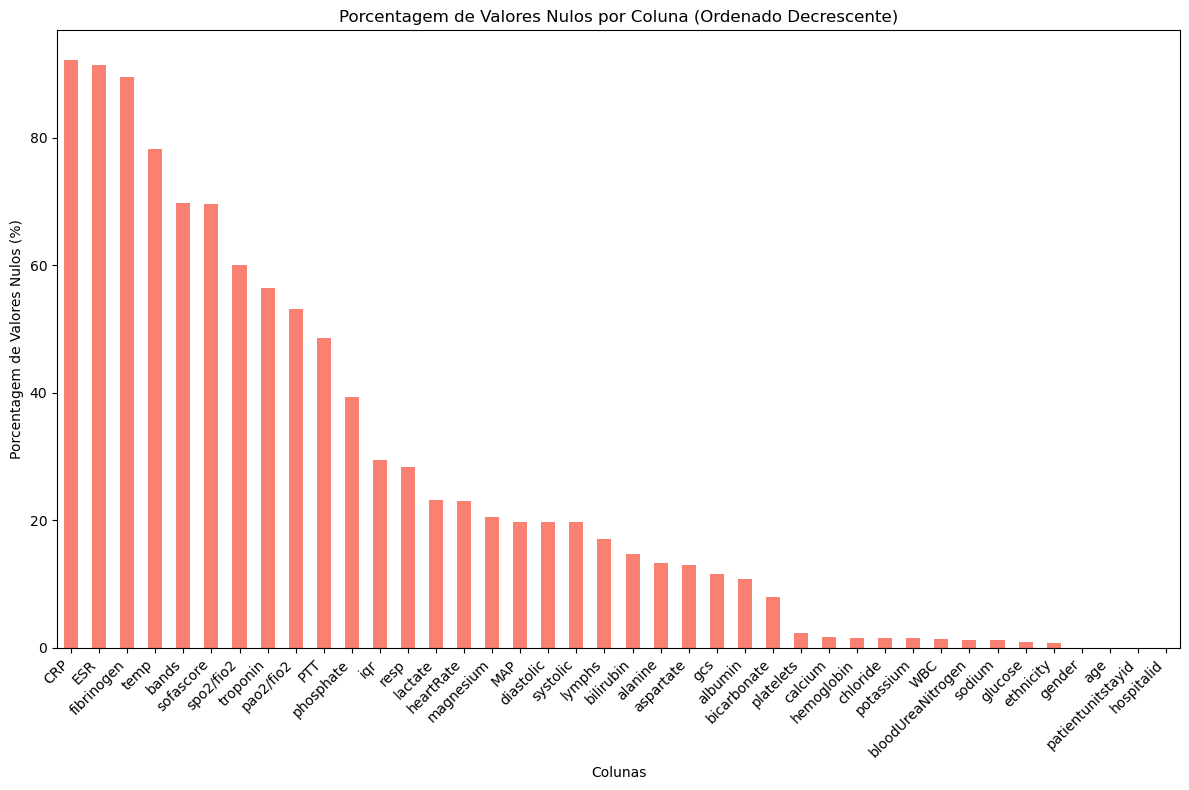

In [18]:
percentual_nulos = (df_eicu.isnull().mean() * 100).sort_values(ascending=False)

# Criar o gráfico de barras
plt.figure(figsize=(12, 8))
percentual_nulos.plot(kind='bar', color='salmon')

# Personalizar o gráfico
plt.title("Porcentagem de Valores Nulos por Coluna (Ordenado Decrescente)")
plt.xlabel("Colunas")
plt.ylabel("Porcentagem de Valores Nulos (%)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Exibir o gráfico
plt.show()

In [20]:
df_teste = df_eicu.drop(columns='hospitalid',axis=1)
df_teste.columns

Index(['patientunitstayid', 'gender', 'age', 'ethnicity', 'bands', 'CRP',
       'ESR', 'temp', 'lactate', 'WBC', 'lymphs', 'resp', 'spo2/fio2',
       'pao2/fio2', 'bicarbonate', 'heartRate', 'troponin', 'systolic',
       'diastolic', 'MAP', 'bloodUreaNitrogen', 'alanine', 'aspartate',
       'bilirubin', 'hemoglobin', 'iqr', 'platelets', 'PTT', 'fibrinogen',
       'albumin', 'chloride', 'glucose', 'sodium', 'gcs', 'potassium',
       'calcium', 'phosphate', 'magnesium', 'sofascore'],
      dtype='object')

In [34]:
df_teste.to_csv('./eicu/df_teste.csv',index=False)

In [21]:
one_hot = pd.get_dummies(df_teste['gender'], prefix='gender')
df_teste = df_teste.drop('gender', axis=1)  # Remove a coluna original, se necessário
df_teste = pd.concat([df_teste, one_hot], axis=1)
one_hot = pd.get_dummies(df_teste['ethnicity'], prefix='ethnicity')
df_teste = df_teste.drop('ethnicity', axis=1)  # Remove a coluna original, se necessário
df_teste = pd.concat([df_teste, one_hot], axis=1)


In [23]:
describe = df_teste[continuous].describe()
describe

,bands,CRP,ESR,temp,lactate,WBC,lymphs,resp,spo2/fio2,pao2/fio2,...,albumin,chloride,glucose,sodium,gcs,potassium,calcium,phosphate,magnesium,sofascore
count,9071.000000,2341.000000,2565.000000,6543.000000,23043.000000,29568.000000,24867.000000,21516.000000,12003.000000,14059.000000,...,26762.000000,29533.000000,29744.000000,29631.000000,26521.000000,29556.000000,29474.000000,18218.000000,23840.000000,9131.000000
mean,15.164470,251.495083,59.934503,37.028320,3.628583,9.188777,7.380336,22.360336,15.556256,10.356413,...,2.444869,105.463014,207.470609,127.267184,13.114287,3.802416,6.752215,3.730497,1.677955,4.939875
std,14.575897,683.373304,35.972445,1.194942,3.575925,7.664462,8.289468,7.667714,55.855319,46.965854,...,1.114523,10.931779,146.616634,32.418180,3.117330,1.153919,2.562731,2.637112,0.377071,2.865743
min,0.000000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009310,0.000000,...,0.200000,48.000000,0.000000,1.025000,3.000000,0.800000,0.079000,0.100000,0.200000,0.000000
25%,4.000000,7.720000,29.000000,37.000000,1.500000,5.500000,3.000000,18.000000,1.980000,0.942857,...,1.900000,96.000000,87.000000,130.000000,13.000000,3.100000,5.800000,2.000000,1.400000,3.000000
50%,11.000000,17.600000,58.000000,37.000000,2.500000,7.920000,5.000000,22.000000,2.657143,1.700000,...,2.300000,108.000000,191.000000,135.000000,15.000000,3.400000,7.500000,2.900000,1.700000,5.000000
75%,21.000000,39.000000,89.000000,37.000000,4.300000,11.100000,9.000000,26.000000,3.849000,2.800000,...,2.800000,113.000000,272.000000,144.000000,15.000000,4.000000,8.100000,5.100000,1.900000,7.000000
max,100.000000,9957.000000,147.000000,41.700000,41.300000,335.500000,100.000000,135.000000,1000.000000,685.714286,...,39.000000,160.000000,2226.000000,281.000000,15.000000,17.000000,240.000000,169.000000,5.700000,16.000000


In [29]:
continuous = [col for col in continuous if pd.api.types.is_numeric_dtype(df_teste[col])]
len(continuous)

35

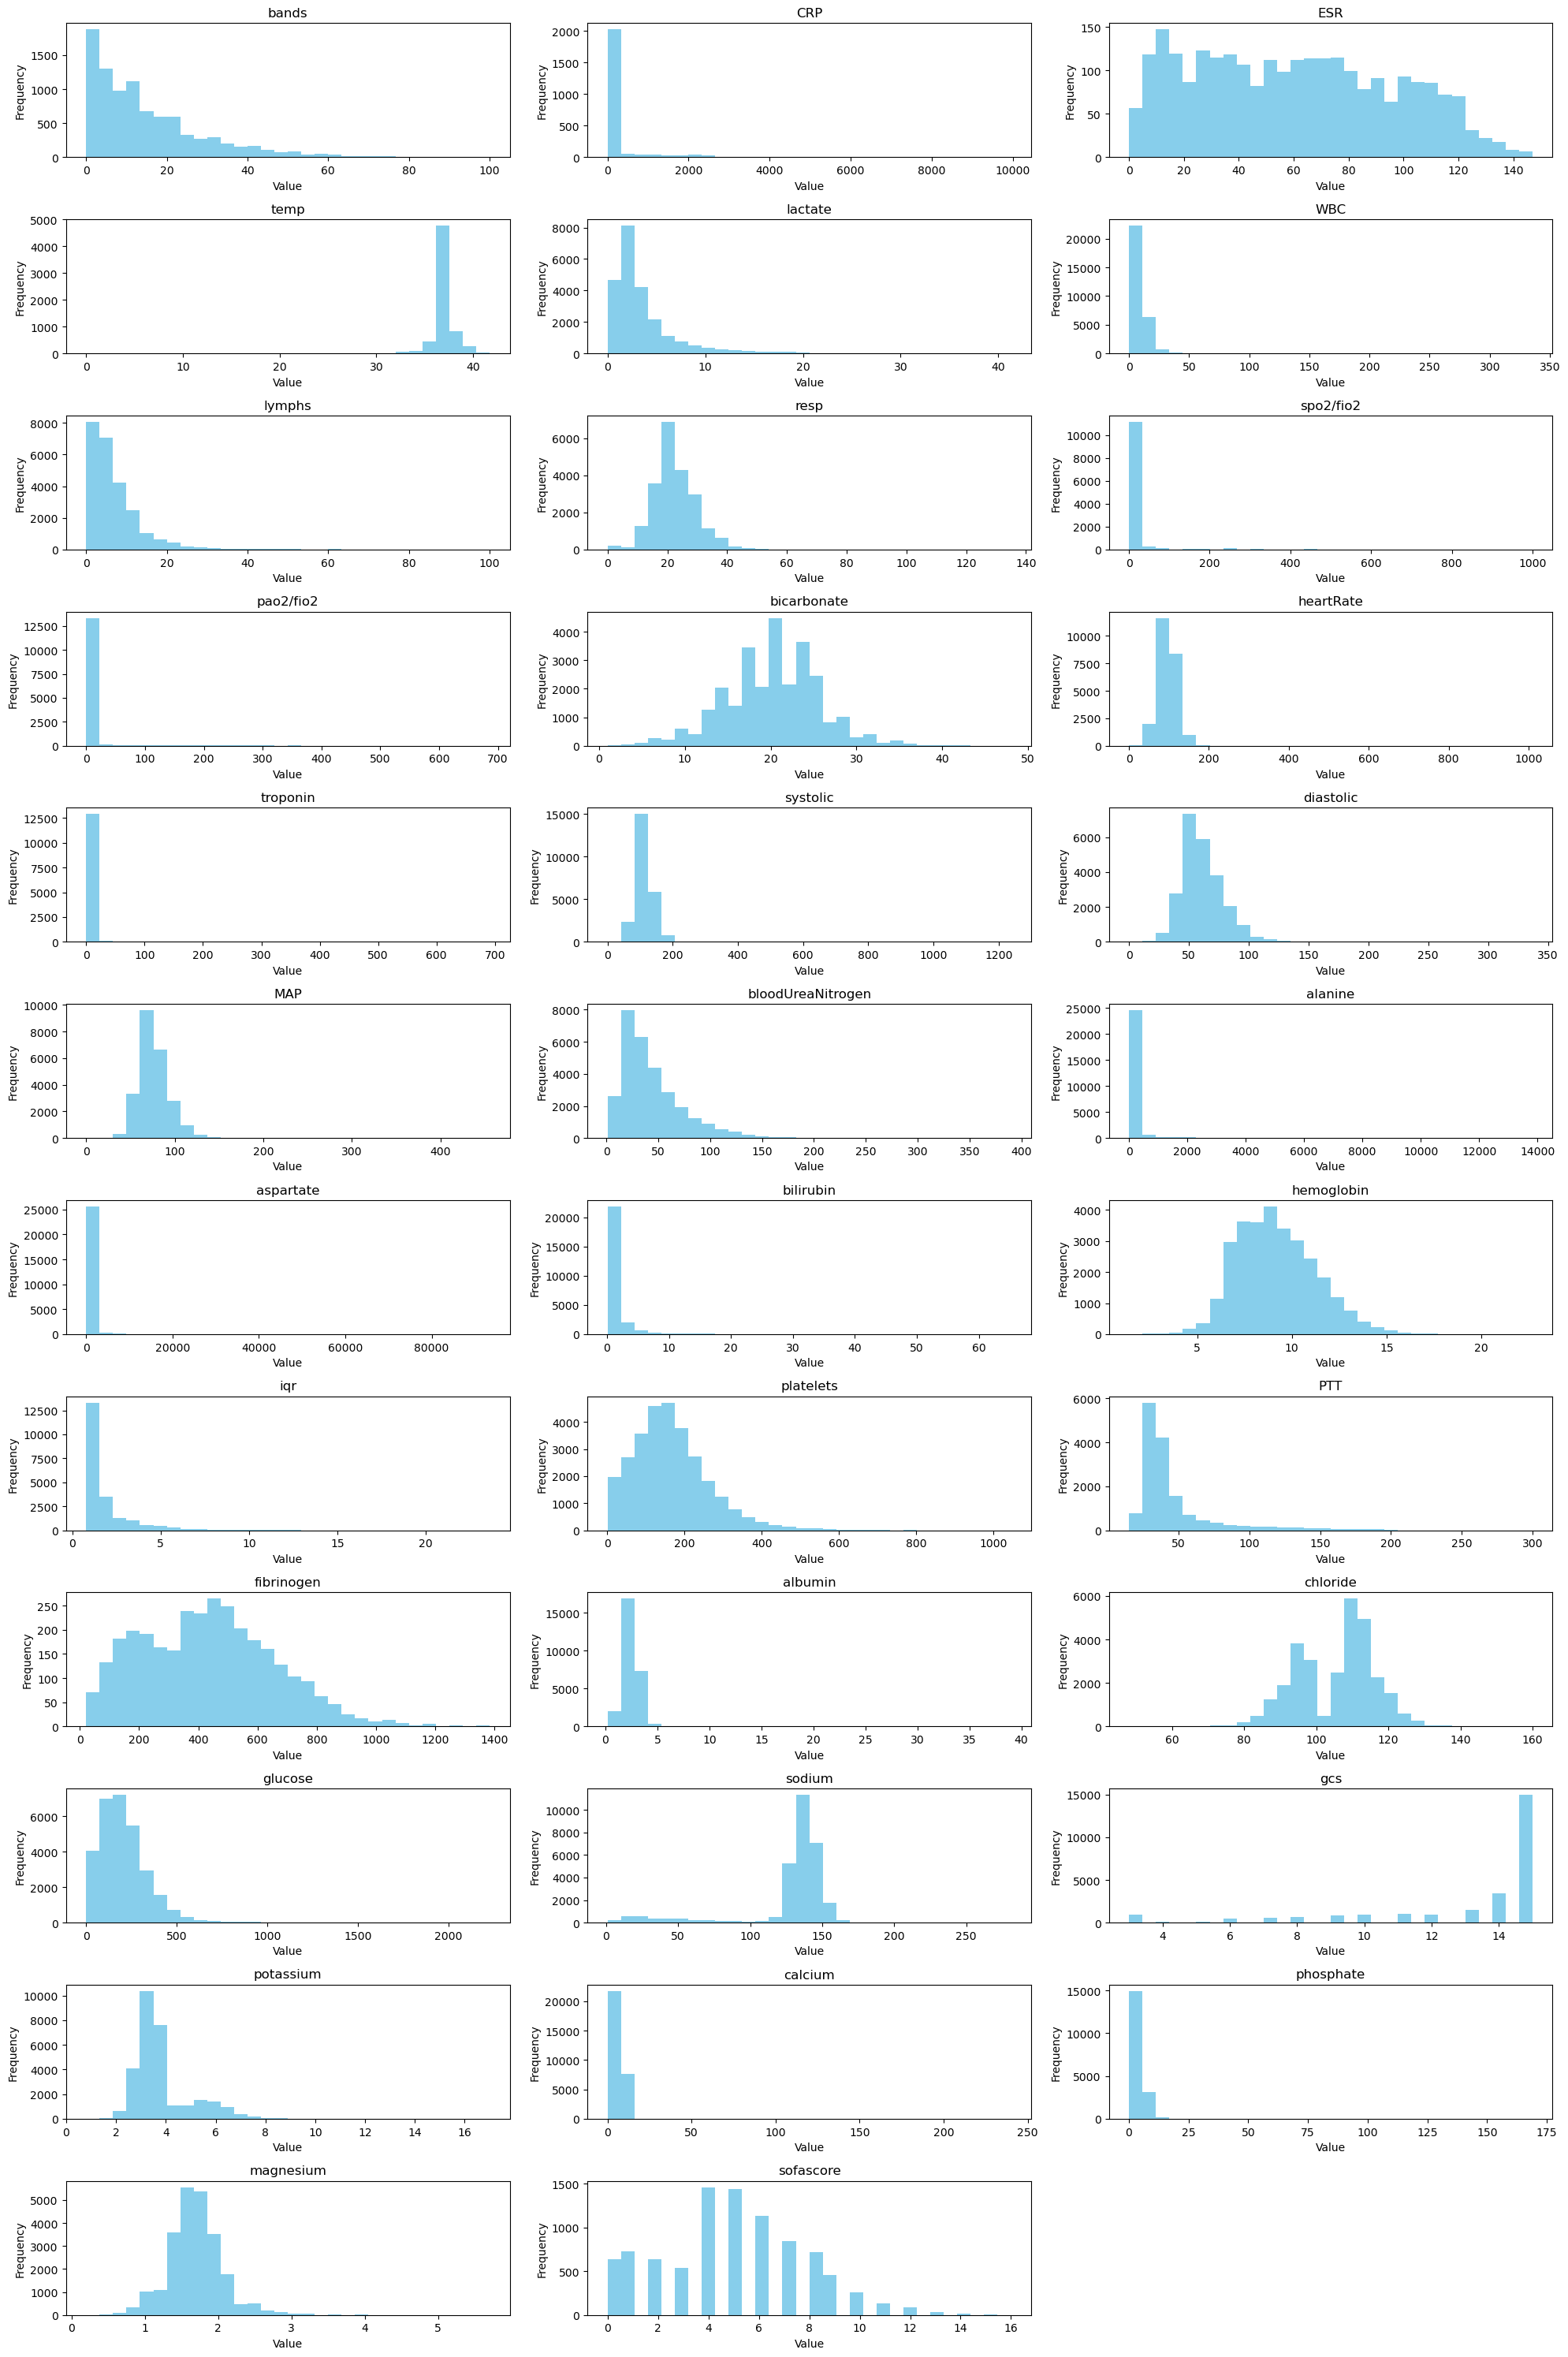

In [30]:


df = df_teste[continuous]

# Definindo o tamanho da figura e o layout 3x12
fig, axes = plt.subplots(12, 3, figsize=(20, 30))
axes = axes.flatten()

# Gerando histogramas para cada coluna
for i, col in enumerate(continuous):
    df[col].dropna().plot(kind='hist', bins=30, ax=axes[i], title=col, color='skyblue')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Removendo subplots vazios (caso haja menos de 36 colunas)
for j in range(len(continuous), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [11]:
info_patients = pd.merge(admissions[['subject_id', 'hadm_id','admission_type','marital_status', 'race']],patients[['subject_id', 'gender', 'anchor_age']], on = 'subject_id',how = 'left')
worst_exams_24h = worst_exams_24h.drop('Unnamed: 0',axis=1)
sofa_worst_24h = sofa_worst_24h.drop(['Unnamed: 0','sofa_24hours'],axis=1)


In [12]:
worst_exams_24h =  pd.merge(worst_exams_24h,info_patients,on = ['subject_id','hadm_id'],how='left')
all_features = pd.merge(worst_exams_24h,sofa_worst_24h,on = ['subject_id','hadm_id'],how='left')

#### Estátisticas da base

In [13]:
exams_columns =  ['ALT', 'AST', 'Albumine', 'Bands', 'Bilirubin',
       'Bun', 'C_reactive', 'Chloride', 'Creatinine', 'ESR', 'Glucose',
       'Heart_rate', 'INR', 'Lactate', 'Oxygen_saturation', 'Respiratory_rate',
       'Sodium', 'Systolic_pressure', 'Temperature', 'WBC', 'Bicarbonate',
       'Hemoglobin','gcs_min' , 'bilirubin_max','creatinine_max',
       'pao2fio2ratio_novent', 'pao2fio2ratio_vent', 'platelet_min','liver_24hours', 'cns_24hours', 'renal_24hours',
       'respiration_24hours', 'coagulation_24hours', 'cardiovascular_24hours','sofa_24hours']
category_columns = ['admission_type',
       'marital_status', 'race', 'gender', 'anchor_age']

In [14]:
df = all_features[exams_columns]
stats = pd.DataFrame({
    'null_percentage': df.isnull().mean() * 100,
    'mean': df.mean(),
    'variance': df.var(),
    'std_dev': df.std(),
    'min': df.min(),
    'max': df.max()
})

# Resetando o índice para que as colunas sejam acessíveis
stats = stats.round(2)
stats.reset_index(inplace=True)
stats.rename(columns={'index': 'column_name'}, inplace=True)
stats = stats.sort_values(by='null_percentage', ascending=False)


In [15]:
df = all_features[category_columns]
stats = pd.DataFrame({
    'null_percentage': df.isnull().mean() * 100,
})

# Resetando o índice para que as colunas sejam acessíveis
stats = stats.round(2)
stats.reset_index(inplace=True)
stats.rename(columns={'index': 'column_name'}, inplace=True)
stats

#### Distribuição dos valores

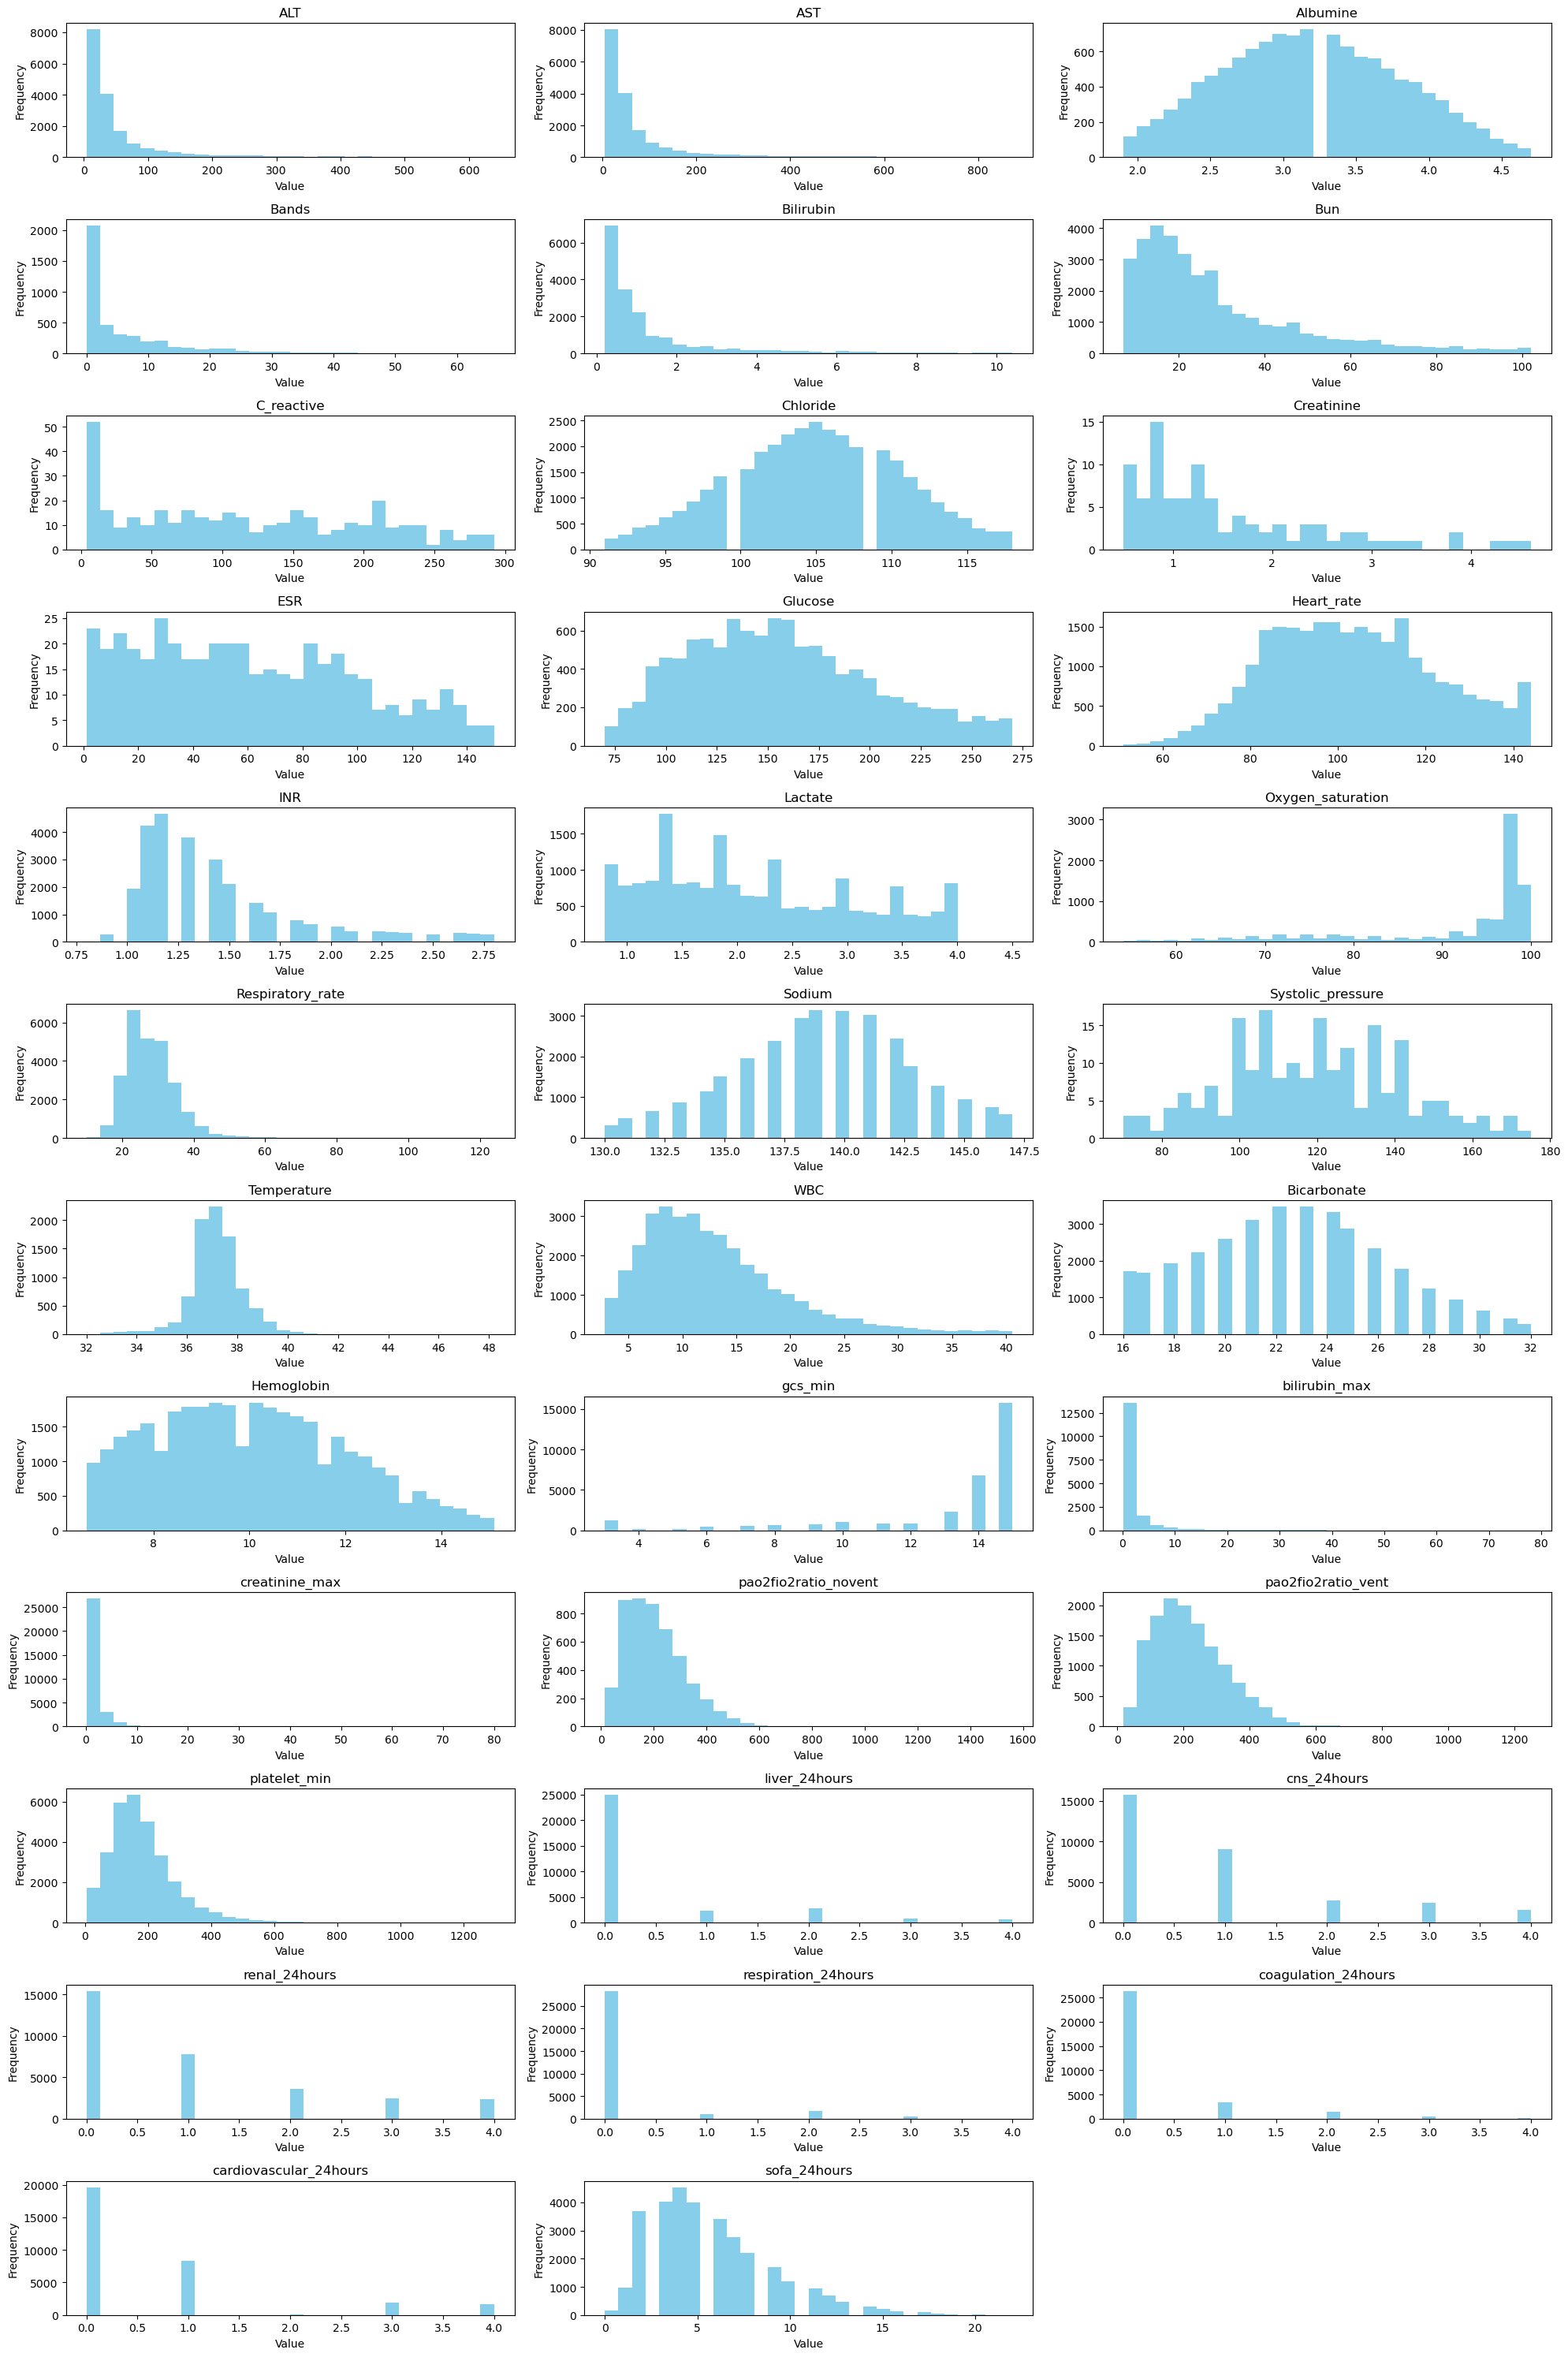

In [16]:
df = all_features[exams_columns]

# Definindo o tamanho da figura e o layout 3x12
fig, axes = plt.subplots(12, 3, figsize=(20, 30))
axes = axes.flatten()

# Gerando histogramas para cada coluna
for i, col in enumerate(exams_columns):
    df[col].dropna().plot(kind='hist', bins=30, ax=axes[i], title=col, color='skyblue')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Removendo subplots vazios (caso haja menos de 36 colunas)
for j in range(len(exams_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


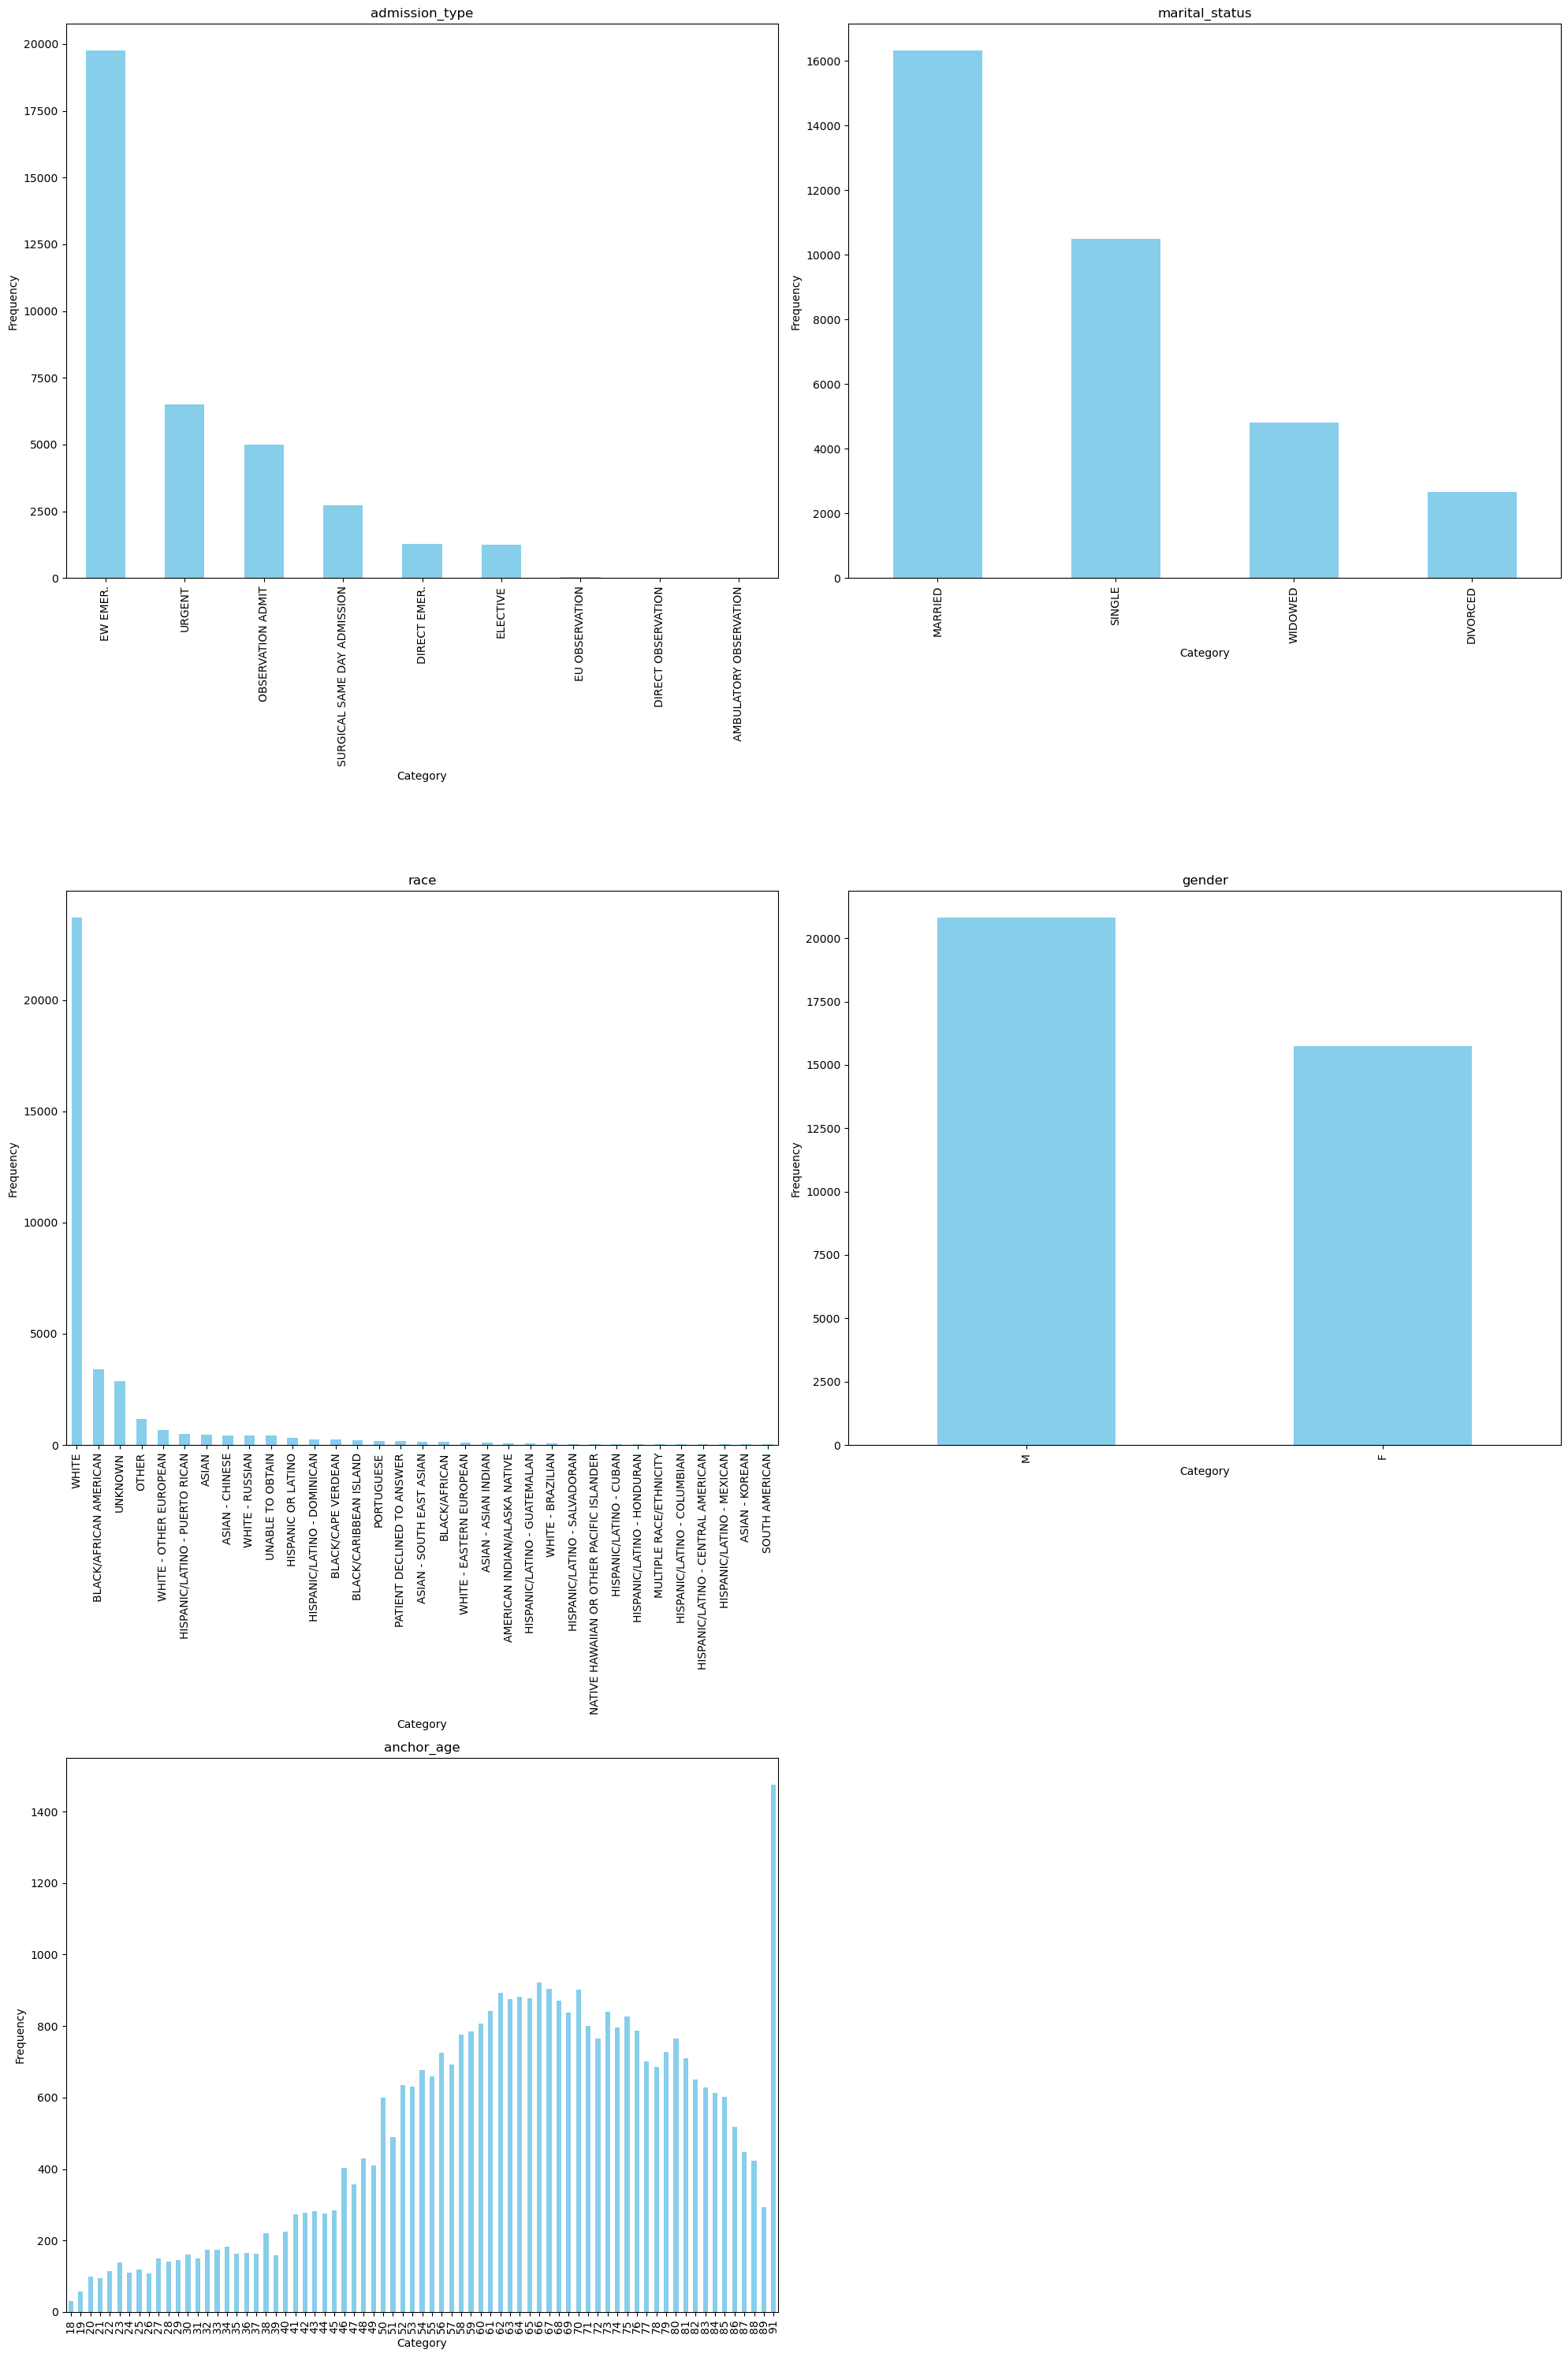

In [17]:
df = all_features[category_columns]

# Definindo a ordem desejada para a coluna anchor_age
anchor_age_order = sorted(df['anchor_age'].dropna().unique(), key=lambda x: int(x))  # Ordena numericamente

# Definindo o tamanho da figura e o layout 3x12
fig, axes = plt.subplots(3, 2, figsize=(20, 30))
axes = axes.flatten()

# Gerando gráficos de barras para cada coluna categórica
for i, col in enumerate(category_columns):
    if col == 'anchor_age':
        df[col].value_counts().reindex(anchor_age_order).plot(kind='bar', ax=axes[i], title=col, color='skyblue')
    else:
        df[col].value_counts().plot(kind='bar', ax=axes[i], title=col, color='skyblue')
    axes[i].set_xlabel('Category')
    axes[i].set_ylabel('Frequency')

# Removendo subplots vazios (caso haja menos de 36 colunas)
for j in range(len(category_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Análise da correlação

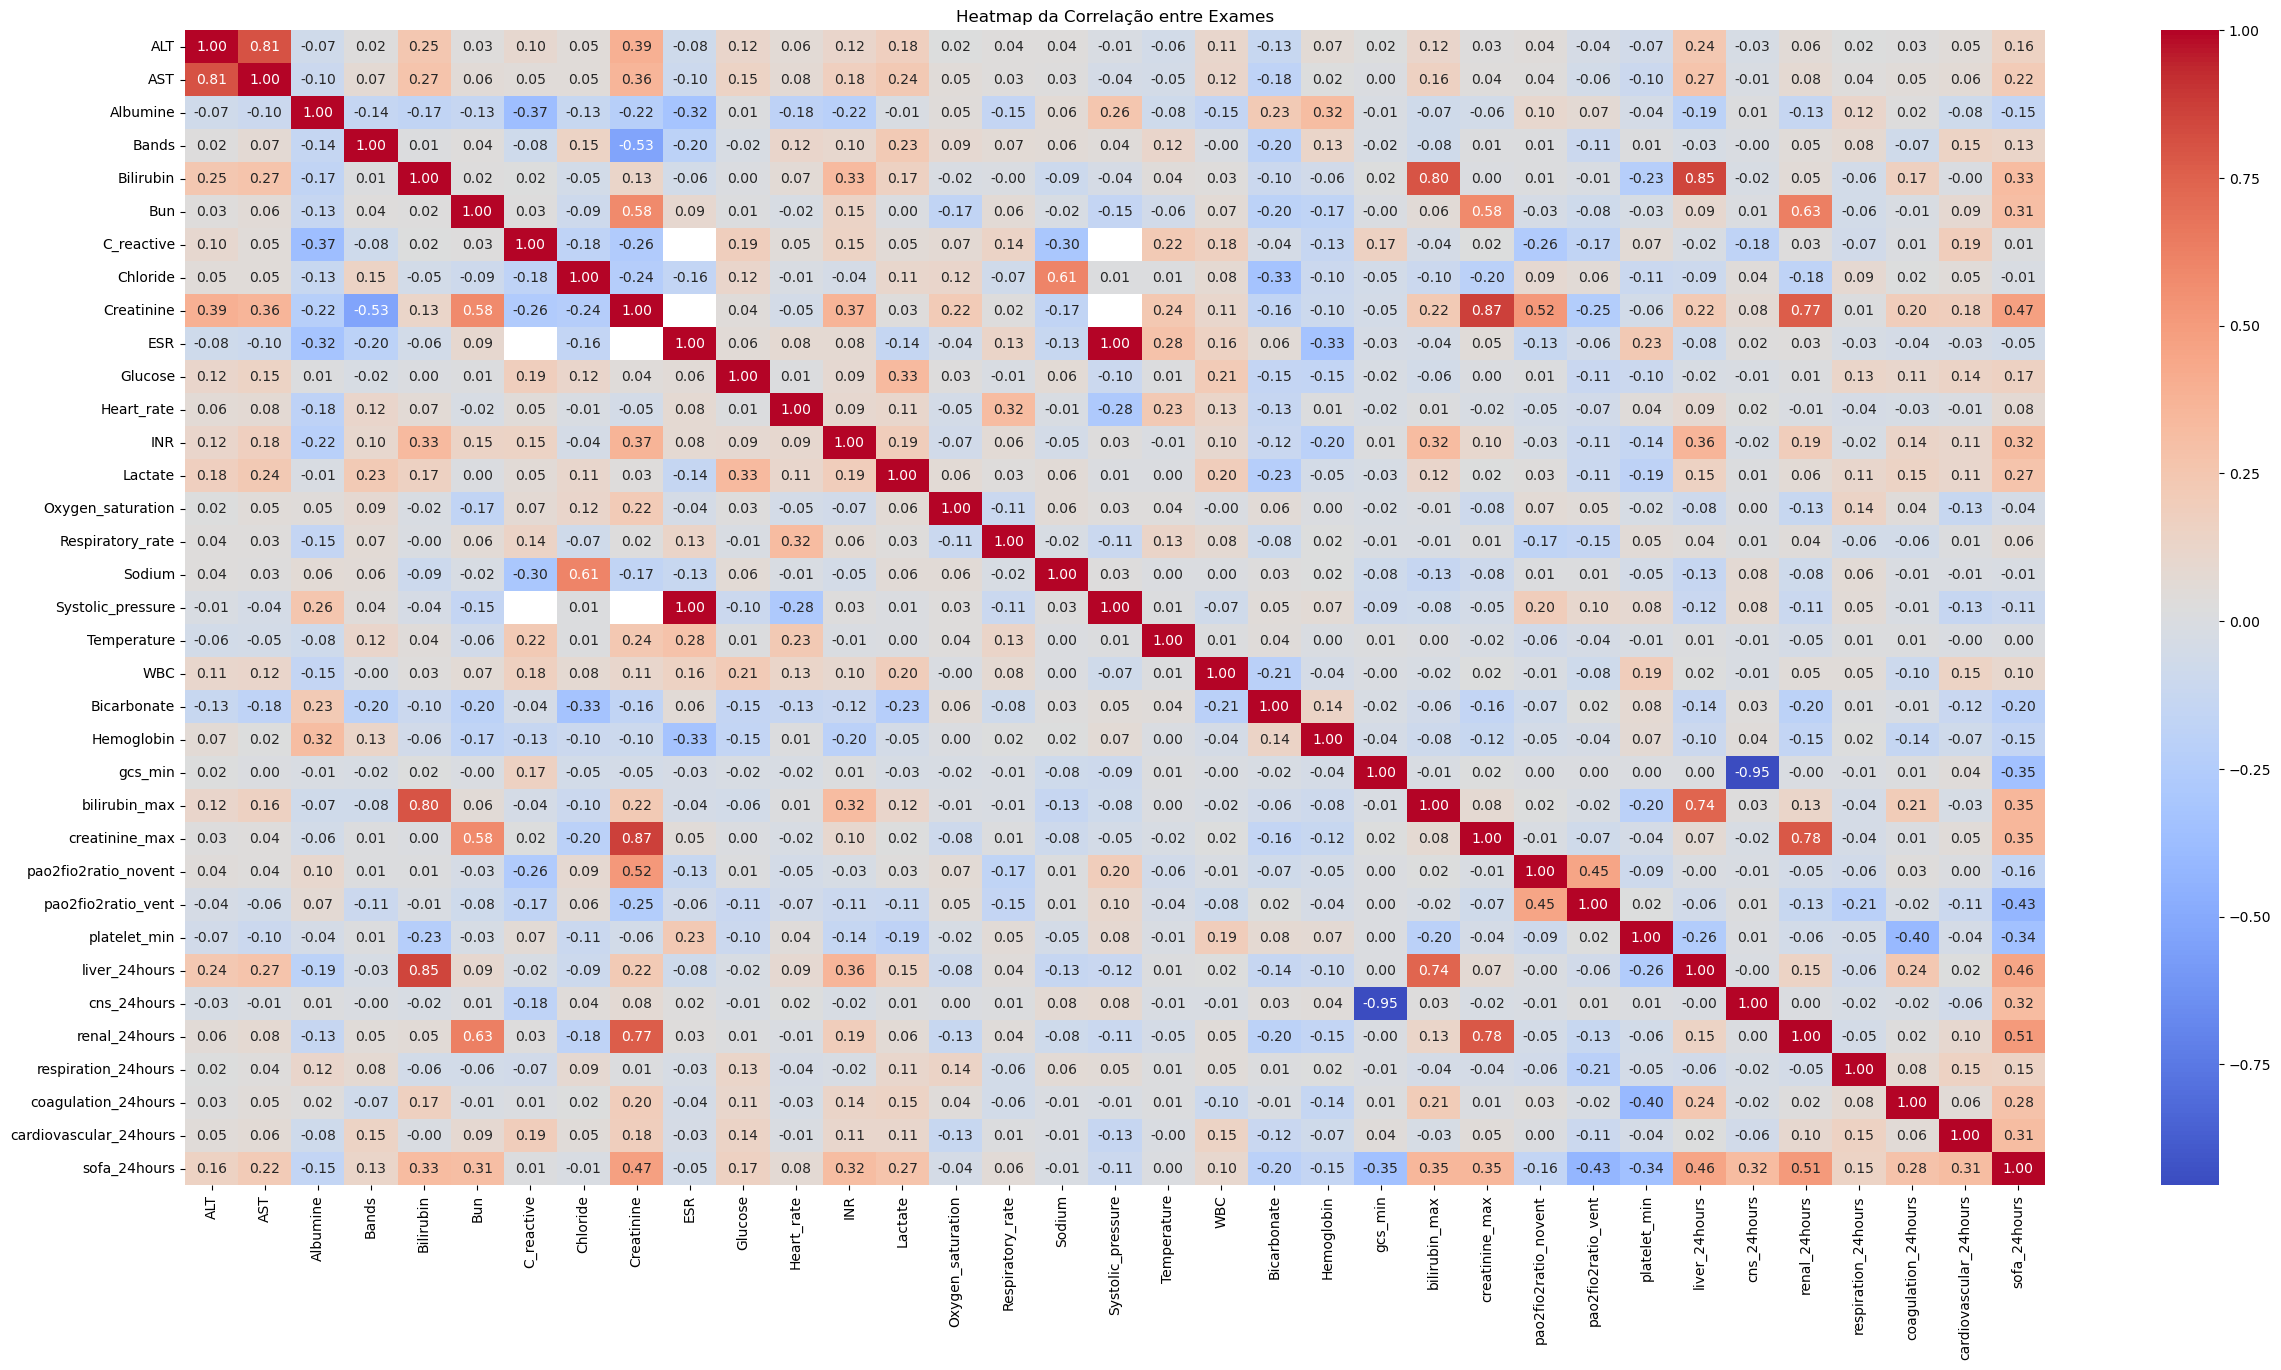

In [18]:
correlation_matrix = all_features[exams_columns].corr()

# Configurando o tamanho da figura
plt.figure(figsize=(30, 15))

# Plotando o heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

# Adicionando título
plt.title('Heatmap da Correlação entre Exames')

# Exibindo o gráfico
plt.show()

In [21]:
all_worst = all_features[['ALT', 'AST', 'Albumine',
       'Bilirubin', 'Bun', 'Chloride', 'Glucose', 'Heart_rate', 'INR',
       'Lactate', 'Oxygen_saturation', 'Respiratory_rate', 'Sodium',
       'Temperature', 'WBC', 'Bicarbonate', 'Hemoglobin', 'sofa_24hours',
       'gcs_min', 'admission_type', 'marital_status', 'race', 'gender',
       'anchor_age', 'creatinine_max', 'pao2fio2ratio_vent', 'platelet_min'
       ]]

In [24]:
exams_columns = ['ALT', 'AST', 'Albumine',
       'Bilirubin', 'Bun', 'Chloride', 'Glucose', 'Heart_rate', 'INR',
       'Lactate', 'Oxygen_saturation', 'Respiratory_rate', 'Sodium',
       'Temperature', 'WBC', 'Bicarbonate', 'Hemoglobin', 'sofa_24hours',
       'gcs_min', 
       'creatinine_max', 'pao2fio2ratio_vent', 'platelet_min']

#### Imputação dos valores nulos

##### KNN

In [25]:

# Separate columns to be imputed and columns to be excluded
columns_to_exclude = ['admission_type', 'marital_status', 'race', 'gender']
columns_to_impute = [col for col in all_worst.columns if col not in columns_to_exclude]

# Separate the data
data_to_impute = all_worst[columns_to_impute]
metadata = all_worst[columns_to_exclude]

# Initialize KNN Imputer
imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors

# Fit and transform the data
imputed_data = imputer.fit_transform(data_to_impute)

# Create a DataFrame for the imputed data
imputed_df = pd.DataFrame(imputed_data, columns=columns_to_impute)

# Recombine with the original metadata
worst_exams_24h_imputed_knn = pd.concat([metadata, imputed_df], axis=1)

worst_exams_24h_imputed_knn


,admission_type,marital_status,race,gender,ALT,AST,Albumine,Bilirubin,Bun,Chloride,...,Temperature,WBC,Bicarbonate,Hemoglobin,sofa_24hours,gcs_min,anchor_age,creatinine_max,pao2fio2ratio_vent,platelet_min
0,DIRECT EMER.,SINGLE,WHITE,F,33.0,105.0,3.10,1.40,7.0,101.8,...,37.62,20.0,30.0,10.7,3.6,11.8,32.0,1.06,333.200000,253.4
1,OBSERVATION ADMIT,MARRIED,WHITE,F,134.0,182.0,2.84,2.32,34.0,106.0,...,37.44,16.5,22.0,9.8,5.8,9.2,89.0,1.38,184.704762,278.0
2,OBSERVATION ADMIT,MARRIED,WHITE,F,49.8,52.4,3.28,0.70,24.0,99.0,...,37.00,18.8,23.0,7.5,5.4,8.8,89.0,1.42,104.033333,297.4
3,OBSERVATION ADMIT,MARRIED,BLACK/AFRICAN AMERICAN,F,47.0,37.0,2.86,0.20,16.0,94.0,...,36.52,6.6,30.0,11.4,4.0,15.0,68.0,1.10,395.313978,149.0
4,SURGICAL SAME DAY ADMISSION,SINGLE,OTHER,F,33.8,39.0,2.84,1.84,16.0,109.0,...,37.70,20.2,23.0,10.2,4.0,15.0,53.0,1.10,180.000000,248.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36576,EW EMER.,SINGLE,WHITE,M,35.0,71.0,2.80,4.40,21.0,103.0,...,37.38,6.8,19.0,10.8,8.0,15.0,56.0,1.30,196.200000,47.0
36577,OBSERVATION ADMIT,SINGLE,MULTIPLE RACE/ETHNICITY,M,69.0,321.0,3.16,8.30,30.6,95.0,...,37.64,5.1,27.0,11.8,8.0,12.0,42.0,0.60,280.309524,33.0
36578,ELECTIVE,DIVORCED,WHITE,M,29.2,26.6,3.54,0.66,12.0,107.0,...,39.52,12.1,23.0,13.9,4.0,10.0,41.0,0.90,397.500000,121.0
36579,EW EMER.,MARRIED,WHITE,M,27.0,25.2,2.72,0.90,56.0,116.0,...,38.30,7.7,19.0,10.4,6.0,11.0,81.0,2.50,112.700000,127.0


##### MissForest

In [26]:
columns_to_exclude = ['admission_type', 'marital_status', 'race', 'gender']
columns_to_impute = [col for col in all_worst.columns if col not in columns_to_exclude]

# Separate the data
data_to_impute = all_worst[columns_to_impute]
metadata = all_worst[columns_to_exclude]

# Initialize MissForest imputer
imputer = MissForest()

# Fit and transform the data
imputed_data = imputer.fit_transform(data_to_impute)

# Create a DataFrame for the imputed data
imputed_df = pd.DataFrame(imputed_data, columns=columns_to_impute)

# Recombine with the original metadata
worst_exams_24h_imputed_missforest = pd.concat([metadata, imputed_df], axis=1)

worst_exams_24h_imputed_missforest


100%|██████████| 5/5 [00:15<00:00,  3.04s/it]


,admission_type,marital_status,race,gender,ALT,AST,Albumine,Bilirubin,Bun,Chloride,...,Temperature,WBC,Bicarbonate,Hemoglobin,sofa_24hours,gcs_min,anchor_age,creatinine_max,pao2fio2ratio_vent,platelet_min
0,DIRECT EMER.,SINGLE,WHITE,F,33.000000,105.000000,3.100000,1.400000,7.000000,97.644248,...,37.167336,20.0,30.0,10.7,4.804692,14.302045,32,0.803195,202.519777,183.299119
1,OBSERVATION ADMIT,MARRIED,WHITE,F,29.706176,34.641834,3.194734,0.523497,34.000000,106.000000,...,37.063393,16.5,22.0,9.8,4.738119,13.254163,89,1.352300,202.000719,184.715768
2,OBSERVATION ADMIT,MARRIED,WHITE,F,28.534438,34.251086,3.098079,0.569385,24.000000,99.000000,...,37.066139,18.8,23.0,7.5,4.243143,13.445145,89,1.209789,204.422913,206.200300
3,OBSERVATION ADMIT,MARRIED,BLACK/AFRICAN AMERICAN,F,47.000000,37.000000,3.417964,0.200000,16.000000,94.000000,...,36.204710,6.6,30.0,11.4,4.000000,15.000000,68,1.100000,200.120223,149.000000
4,SURGICAL SAME DAY ADMISSION,SINGLE,OTHER,F,28.509548,42.090477,3.270992,0.648381,16.000000,109.000000,...,37.700000,20.2,23.0,10.2,4.000000,15.000000,53,1.100000,180.000000,248.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36576,EW EMER.,SINGLE,WHITE,M,35.000000,71.000000,2.800000,2.968679,21.000000,103.000000,...,36.991041,6.8,19.0,10.8,8.000000,15.000000,56,1.300000,252.854379,47.000000
36577,OBSERVATION ADMIT,SINGLE,MULTIPLE RACE/ETHNICITY,M,69.000000,321.000000,2.877330,8.300000,12.586619,95.000000,...,37.107937,5.1,27.0,11.8,8.000000,12.000000,42,0.600000,270.855642,33.000000
36578,ELECTIVE,DIVORCED,WHITE,M,30.387462,40.429375,3.425106,0.737186,12.000000,107.000000,...,37.535232,12.1,23.0,13.9,4.000000,10.000000,41,0.900000,397.500000,121.000000
36579,EW EMER.,MARRIED,WHITE,M,27.943391,40.887419,2.915513,0.492412,56.000000,116.000000,...,38.300000,7.7,19.0,10.4,6.000000,11.000000,81,2.500000,244.365207,127.000000


##### Análise dos valores gerados

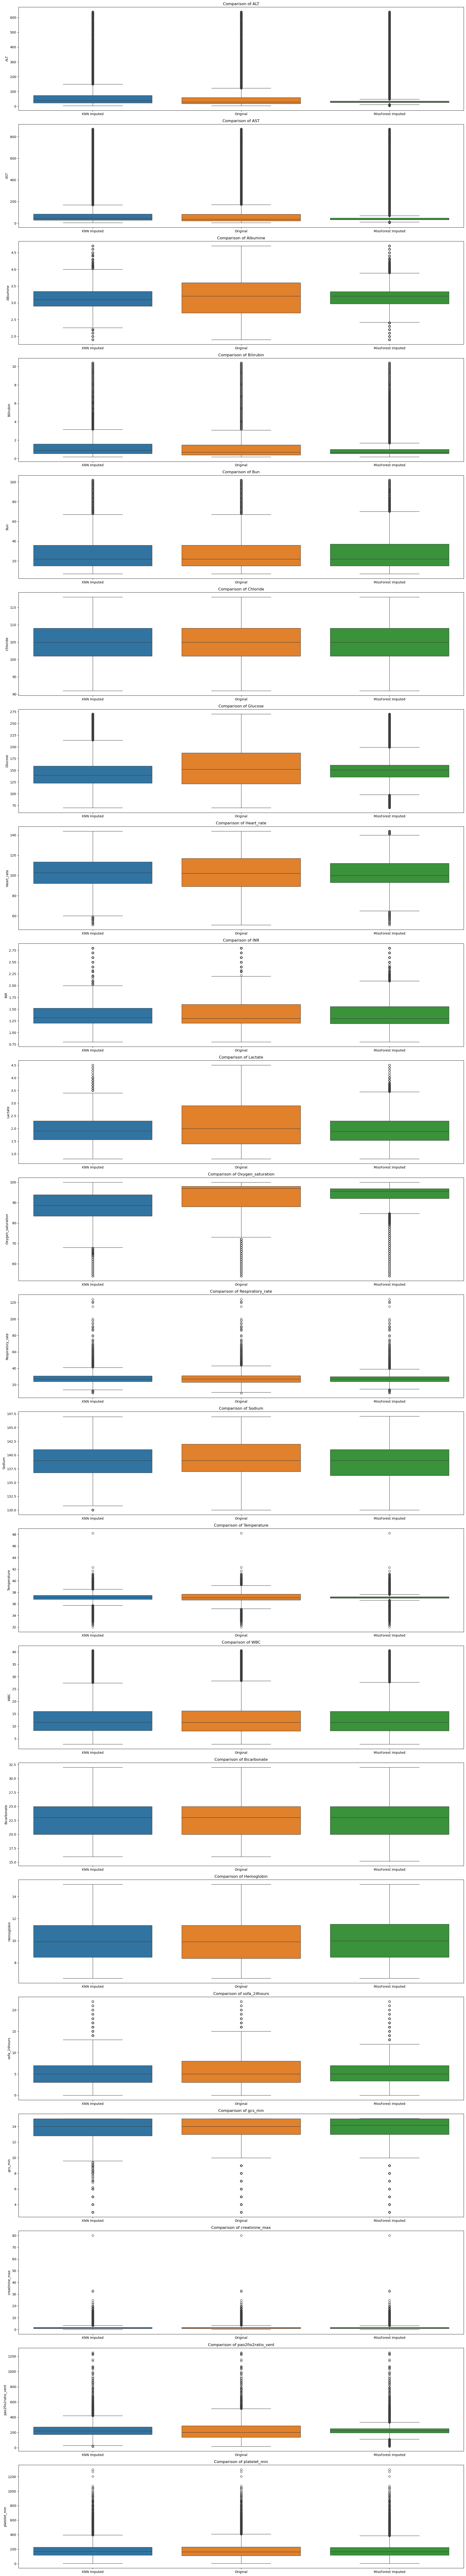

In [30]:
features = exams_columns

# Configuração dos subplots
n_features = len(features)
fig, axes = plt.subplots(n_features, 1, figsize=(20, 5 * n_features))

# Loop sobre as features para criar os boxplots
for i, feature in enumerate(features):
    # Criando o DataFrame combinado para cada feature
    combined_df = pd.DataFrame({
        'KNN Imputed': worst_exams_24h_imputed_knn[feature],
        'Original': all_worst[feature],
        'MissForest Imputed': worst_exams_24h_imputed_missforest[feature]
    })

    # Criando o boxplot
    sns.boxplot(data=combined_df, ax=axes[i])
    axes[i].set_title(f'Comparison of {feature}')
    axes[i].set_ylabel(feature)

# Ajuste o layout para evitar sobreposição
plt.tight_layout()
plt.show()
